In [82]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sb
from analyze_experiment_in_progress import get_data_from_logs
sb.set()

In [87]:
#bert4rec outperforms everything
#experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'

#SALREC-BCE-Great
#experiment_logs = './results/bert4rec_config_2021_11_07T22_26_10/stdout'


#SALREC-Lambdarank 0.157107
#experiment_logs = './results/ml_benchmark20m_2021_11_18T16_38_37/stdout'



#Transformer-Lambdarank 0.1603
#experiment_logs = './results/ml_benchmark20m_2021_11_19T17_43_30/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_23T14_39_04/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_25T09_41_35/stdout'

#Fast Lambdarank on dekstop
#experiment_logs = './results/ml_benchmark20m_2021_11_27T23_55_22/stdout'


#Fast Lambdarank on dekstop - 40k, bce slightly better
#experiment_logs = './results/ml_benchmark20m_2021_11_28T08_36_11/stdout'


# Learning rate effects:

# Lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_11_26T10_36_55/stdout"
#BCE
#experiment_logs = "./results/ml_benchmark20m_2021_11_27T11_36_03/stdout"



#Truncation effects: 
#1-20
#experiment_logs = "./results/ml_benchmark20m_2021_11_28T18_14_50/stdout"

#30-120
#experiment_logs = "./results/ml_benchmark20m_2021_11_29T15_12_00/stdout"


#stream -first run: 
#experiment_logs = "./results/steam_benchmark_2021_12_02T16_41_29/stdout"

#steam - num targets
#experiment_logs = "./results/steam_benchmark_2021_12_04T12_47_09/stdout"


#lambda norm effect:
#experiment_logs = "results/ml_benchmark20m_2021_12_02T10_46_35/stdout"

#truncated lambdarank with bce
#experiment_logs = "./results/ml_benchmark20m_2021_12_05T21_30_29/stdout"


#lambdarank-truncated fixed

#experiment_logs = "./results/ml_benchmark20m_2021_12_07T20_37_41/stdout"



#lambdarank-truncated-bce-focus
#experiment_logs = "./results/ml_benchmark20m_2021_12_08T07_39_20/stdout"

#important test
#experiment_logs = "./results/ml_benchmark20m_2021_12_09T09_28_21/stdout"


#12 hours experiment with truncated lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_12_12T20_24_03/stdout"



#lambda normalization 
#experiment_logs = "./results/lambda_normalization_experiment_2021_12_14T17_33_27/stdout"


#gru4rec experiment
#experiment_logs = "./results/ml_benchmark1m_2021_12_15T18_36_26/stdout"

#sasrec-booking
#experiment_logs = "results/booking_benchmark_2021_12_23T21_31_04/stdout"

#experiment_logs = "./results/booking_benchmark_2021_12_25T17_43_29/stdout"


#top-1 experiment
experiment_logs = "./results/ml_benchmark20m_2021_12_26T22_18_58/stdout"

In [88]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [89]:
data = get_data_from_logs(experiment_logs, 0)

In [90]:
df = pd.DataFrame(data).set_index('model_name')

df.sort_values('ndcg@10')

,HIT@1,HIT@5,HIT@10,ndcg@5,ndcg@10,MRR,HIT@4,ndcg@40,sampled_metrics,model_build_time,model_inference_time,model_metadata,num_epochs,metrics_history
model_name,,,,,,,,,,,,,,
top,0.008053,0.031601,0.051122,0.020075,0.026364,0.024987,0.027086,0.042113,"{'HIT@1': 0.3041727672035139, 'HIT@5': 0.6692288921425086, 'HIT@10': 0.8272327964860908, 'ndcg@5': 0.49602775650444275, 'ndcg@10': 0.5473159174202236, 'MRR': 0.46999856442685456, 'HIT@4': 0.6143240605173256, 'ndcg@40': 0.5866365823138362}",0.041388,11.515392,{'proxy_model': 'filter_seen_recommender'},0,[]
lightfm-bpr,0.014519,0.046730,0.081991,0.030529,0.041756,0.039316,0.040020,0.070255,"{'HIT@1': 0.4210590531966813, 'HIT@5': 0.7429233772571986, 'HIT@10': 0.8399219131283553, 'ndcg@5': 0.5938237757614875, 'ndcg@10': 0.6254971584877087, 'MRR': 0.5641293068711536, 'HIT@4': 0.7080283064909713, 'ndcg@40': 0.6490508212276209}",283.397561,280.504373,{'proxy_model': 'filter_seen_recommender'},0,[]
SASRec-BPR-max-TimeLimit:1h-lastonly:Fasle,0.015495,0.051489,0.084675,0.033541,0.044160,0.042181,0.043436,0.072926,"{'HIT@1': 0.4575402635431918, 'HIT@5': 0.8289409468033186, 'HIT@10': 0.920448999511957, 'ndcg@5': 0.6575654349209703, 'ndcg@10': 0.6875166732900646, 'MRR': 0.6170720943263585, 'HIT@4': 0.7919716935090287, 'ndcg@40': 0.7031154569992657}",3620.258124,327.174311,"{'epochs_trained': 58, 'best_val_ndcg': 0.04684005677700043, 'val_ndcg_history': [[39.30698752403259, 0.013017978519201279], [84.75211668014526, 0.014697025530040264], [130.17508745193481, 0.013689246028661728], [175.61862802505493, 0.01350510492920875...",80,"[{'loss': 1.3557e-05, 'ndcg_at_10': 0.1362, 'val_loss': 1.8715e-05, 'val_ndcg_at_10': 0.013, 'epoch': 1, 'val_ndcg': 0.01302, 'best_ndcg': 0.01302, 'steps_since_improved': 0.0, 'total_training_time': 39.30698752403259}, {'loss': 9.9361e-06, 'ndcg_at_10..."
SASRec-BCE-TimeLimit:1h-lastonly:False,0.012567,0.054783,0.095168,0.032988,0.045901,0.043005,0.044290,0.081061,"{'HIT@1': 0.5069546120058566, 'HIT@5': 0.8694485114690093, 'HIT@10': 0.9460712542703757, 'ndcg@5': 0.7039624457866466, 'ndcg@10': 0.7291267706335128, 'MRR': 0.6624881742896825, 'HIT@4': 0.8316251830161054, 'ndcg@40': 0.7416989901437923}",3607.859454,323.390913,"{'epochs_trained': 70, 'best_val_ndcg': 0.04172822833061218, 'val_ndcg_history': [[20.89246940612793, 0.019653640687465668], [48.118722677230835, 0.016709037125110626], [75.79828643798828, 0.0226640272885561], [103.56729888916016, 0.024659082293510437]...",131,"[{'loss': 0.0346, 'ndcg_at_10': 0.1574, 'val_loss': 0.0036, 'val_ndcg_at_10': 0.0197, 'epoch': 1, 'val_ndcg': 0.01965, 'best_ndcg': 0.01965, 'steps_since_improved': 0.0, 'total_training_time': 20.89246940612793}, {'loss': 0.0131, 'ndcg_at_10': 0.1801, ..."
SASRec-BPR-TimeLimit:1h-lastonly:True,0.024402,0.075281,0.115056,0.050287,0.063058,0.056365,0.064544,0.089561,"{'HIT@1': 0.42947779404587605, 'HIT@5': 0.7381649585163494, 'HIT@10': 0.8408979990239142, 'ndcg@5': 0.5935388663578615, 'ndcg@10': 0.6269264672599782, 'MRR': 0.5667996986872346, 'HIT@4': 0.6992435334309419, 'ndcg@40': 0.6545676125254236}",3620.717977,331.428703,"{'epochs_trained': 127, 'best_val_ndcg': 0.05246114730834961, 'val_ndcg_history': [[17.20632815361023, 0.02487240359187126], [40.88415455818176, 0.030938884243369102], [64.58030033111572, 0.03656810149550438], [88.235915184021, 0.043134115636348724], [...",154,"[{'loss': 0.1456, 'ndcg_at_10': 0.0183, 'val_loss': 0.1224, 'val_ndcg_at_10': 0.0249, 'epoch': 1, 'val_ndcg': 0.02487, 'best_ndcg': 0.02487, 'steps_since_improved': 0.0, 'total_training_time': 17.20632815361023}, {'loss': 0.0837, 'ndcg_at_10': 0.0259, ..."
SASRec-Lambdarank-Truncated:2500-TimeLimit:1h-lastonly:True,0.034163,0.087360,0.123231,0.061387,0.072910,0.066094,0.075281,0.098268,"{'HIT@1': 0.41678867740361153, 'HIT@5': 0.7010736944851147, 'HIT@10': 0.7988042947779405, 'ndcg@5': 0.5684431921360313, 'ndcg@10': 0.6002858751465731, 'MRR': 0.5445786788166653, 'HIT@4': 0.6652025378233285, 'ndcg@40': 0.622524599587338

0 dict_keys([0])
1 dict_keys([0, 1])


<Figure size 1152x648 with 0 Axes>

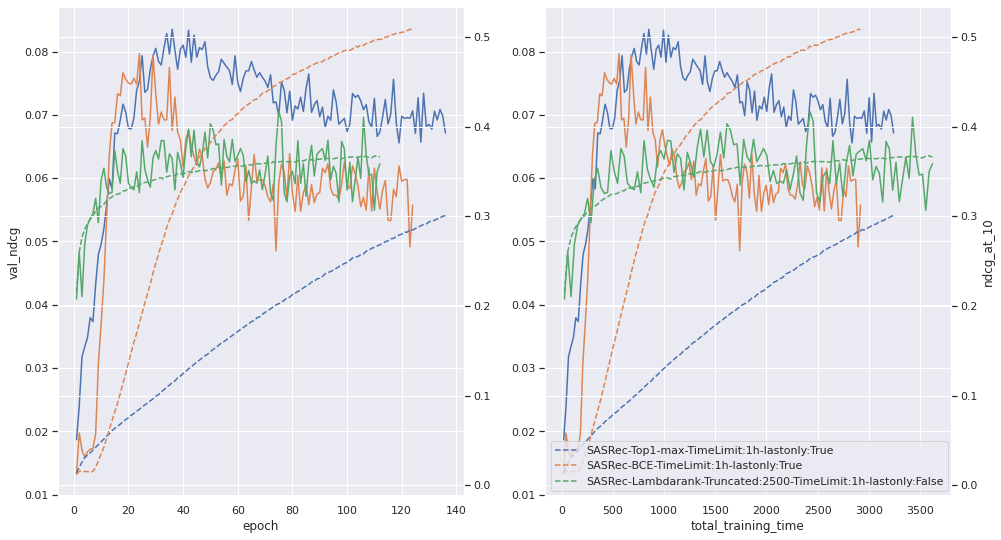

In [92]:
moving_average_steps=1
max_points = 100000


def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']

fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

interesting_models = ['SASRec-Top1-max-TimeLimit:1h-lastonly:True', 
                      'SASRec-BCE-TimeLimit:1h-lastonly:True', 
                      'SASRec-Lambdarank-Truncated:2500-TimeLimit:1h-lastonly:False']
second_metrics = {}

for recommender in data:
    if recommender['model_name'] not in interesting_models:
        continue
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg'
        second_metric_name = 'ndcg_at_10'
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)[:max_points]
        if second_metric_name != None:
            second_metric = moving_average(get_metric(history, second_metric_name), moving_average_steps)[:max_points]
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:][:max_points]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            
            ax[axis_num].set_xlabel(axis_name)
            if axis_num == 0:
                ax[axis_num].set_ylabel(metric_name)
            
            if (second_metric_name != None):
                if axis_num not in second_metrics:
                    second_metrics[axis_num] = ax[axis_num].twinx()
                    print(axis_num, second_metrics.keys())
                ax2 = second_metrics[axis_num]
                if axis_num == 1:
                    ax2.set_ylabel(second_metric_name)
                ax2.plot(axis, second_metric, '--', label=recommender['model_name'],)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


### len(metric), len(metric) - np.argmax(metric) - 1

In [45]:
np.argmax(metric)

76